# KITTI Segmentation Sandbox

This notebook cycles through KITTI training images and performs pixel-wise semantic segmentation with comprehensive visualization and evaluation.

## Overview

We'll process KITTI dataset images using our PointPainting segmentation model to:
1. Load and visualize original images
2. Generate pixel-wise segmentation predictions
3. Compare predictions with ground truth (if available)
4. Evaluate segmentation quality with proper legends and metrics
5. Analyze class distribution and model performance

The goal is to assess how well our segmentation model performs on automotive scenes before using it for PointPainting.

In [1]:
# Import Required Libraries
import sys
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import cv2
from PIL import Image
import torch
import random
from tqdm import tqdm
import seaborn as sns
from collections import defaultdict

# Add src directory to path for our custom modules
sys.path.append(str(Path().absolute().parent / "src"))

from pointpainting import (
    SemanticSegmentationModel,
    KITTIDataLoader
)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

print("Libraries imported successfully!")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA device: NVIDIA GeForce RTX 2060
Libraries imported successfully!


## Load KITTI Dataset

Set up paths and load the KITTI dataset for image segmentation analysis.

In [2]:
# Configuration
KITTI_ROOT = r"F:\datasets\kitti"
OUTPUT_DIR = "../outputs/segmentation_sandbox"
NUM_SAMPLES = 10  # Number of images to process for this demo

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Device configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Initialize KITTI data loader
try:
    data_loader = KITTIDataLoader(KITTI_ROOT, split="training")
    print(f"Successfully loaded KITTI dataset with {len(data_loader)} samples")
    
    # Get random sample of images for testing
    all_sample_ids = data_loader.sample_ids
    test_sample_ids = random.sample(all_sample_ids, min(NUM_SAMPLES, len(all_sample_ids)))
    print(f"Selected {len(test_sample_ids)} samples for segmentation testing: {test_sample_ids}")
    
except Exception as e:
    print(f"Error loading KITTI dataset: {e}")
    print("Please ensure the dataset is properly extracted at the specified path")

Using device: cuda


INFO:pointpainting.data_loader:Initialized KITTI loader for training split with 7481 samples


Successfully loaded KITTI dataset with 7481 samples
Selected 10 samples for segmentation testing: ['005238', '000912', '000204', '006074', '002253', '002006', '001828', '001143', '006033', '000839']


## Define Segmentation Classes and Color Mapping

Define the class labels and create a color mapping for visualization with proper legends.

In [3]:
# Define class names and colors for KITTI segmentation
CLASS_NAMES = ["background", "car", "pedestrian", "cyclist"]
NUM_CLASSES = len(CLASS_NAMES)

# Define colors for each class (RGB format)
CLASS_COLORS = {
    "background": [128, 128, 128],    # Gray
    "car": [255, 0, 0],               # Red
    "pedestrian": [0, 255, 0],        # Green
    "cyclist": [0, 0, 255],           # Blue
}

# Create color array for visualization
color_array = np.array([CLASS_COLORS[name] for name in CLASS_NAMES])
print("Class definitions:")
for i, (name, color) in enumerate(zip(CLASS_NAMES, color_array)):
    print(f"  {i}: {name} - RGB{tuple(color)}")

# Create matplotlib colormap
colors_normalized = color_array / 255.0
custom_cmap = ListedColormap(colors_normalized)

def create_legend_patches():
    """Create legend patches for the segmentation classes."""
    patches_list = []
    for i, (name, color) in enumerate(zip(CLASS_NAMES, color_array)):
        patch = patches.Patch(color=color/255.0, label=f"{i}: {name}")
        patches_list.append(patch)
    return patches_list

print("Color mapping created successfully!")

Class definitions:
  0: background - RGB(np.int64(128), np.int64(128), np.int64(128))
  1: car - RGB(np.int64(255), np.int64(0), np.int64(0))
  2: pedestrian - RGB(np.int64(0), np.int64(255), np.int64(0))
  3: cyclist - RGB(np.int64(0), np.int64(0), np.int64(255))
Color mapping created successfully!


## Load and Preprocess Images

Create functions to load and preprocess images for segmentation.

In [4]:
def load_and_preprocess_image(sample_id, data_loader):
    """
    Load and preprocess a KITTI image for segmentation.
    
    Args:
        sample_id: KITTI sample identifier
        data_loader: KITTIDataLoader instance
    
    Returns:
        tuple: (original_image, preprocessed_image)
    """
    try:
        # Load image
        image = data_loader.load_image(sample_id)
        
        # Convert to RGB if needed (PIL already loads as RGB)
        if len(image.shape) == 3 and image.shape[2] == 3:
            original_image = image.copy()
        else:
            raise ValueError(f"Unexpected image shape: {image.shape}")
        
        return original_image, original_image
        
    except Exception as e:
        print(f"Error loading image {sample_id}: {e}")
        return None, None

def convert_probabilities_to_colored_mask(predictions, class_colors):
    """
    Convert class probability predictions to colored segmentation mask.
    
    Args:
        predictions: Class predictions (H, W) with class indices
        class_colors: Array of RGB colors for each class
    
    Returns:
        Colored segmentation mask (H, W, 3)
    """
    height, width = predictions.shape
    colored_mask = np.zeros((height, width, 3), dtype=np.uint8)
    
    for class_idx in range(len(class_colors)):
        mask = predictions == class_idx
        colored_mask[mask] = class_colors[class_idx]
    
    return colored_mask

def overlay_segmentation(image, segmentation_mask, alpha=0.6):
    """
    Overlay segmentation mask on original image.
    
    Args:
        image: Original image (H, W, 3)
        segmentation_mask: Colored segmentation mask (H, W, 3)
        alpha: Transparency of overlay
    
    Returns:
        Overlaid image
    """
    # Ensure both images are uint8
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8) if image.max() <= 1.0 else image.astype(np.uint8)
    if segmentation_mask.dtype != np.uint8:
        segmentation_mask = segmentation_mask.astype(np.uint8)
    
    # Blend images
    overlaid = cv2.addWeighted(image, 1-alpha, segmentation_mask, alpha, 0)
    return overlaid

print("Image preprocessing functions defined!")

Image preprocessing functions defined!


## Perform Pixelwise Segmentation

Initialize the segmentation model and create functions to perform pixel-wise classification.

In [5]:
# Initialize semantic segmentation model
print("Initializing semantic segmentation model...")

segmentation_model = SemanticSegmentationModel(
    num_classes=NUM_CLASSES,
    device=device,
    pretrained=True
)

print(f"Model initialized on {device}")
print(f"Model expects {NUM_CLASSES} classes: {CLASS_NAMES}")

def perform_segmentation(image, model):
    """
    Perform pixel-wise segmentation on an image.
    
    Args:
        image: Input image (H, W, 3)
        model: Segmentation model
    
    Returns:
        tuple: (class_probabilities, class_predictions, confidence_map)
    """
    try:
        # Get segmentation probabilities
        probabilities = model.predict(image, return_probabilities=True)
        
        # Get class predictions
        predictions = np.argmax(probabilities, axis=2)
        
        # Get confidence map (max probability for each pixel)
        confidence = np.max(probabilities, axis=2)
        
        return probabilities, predictions, confidence
        
    except Exception as e:
        print(f"Error during segmentation: {e}")
        return None, None, None

def analyze_segmentation_stats(predictions, probabilities, class_names):
    """
    Analyze segmentation statistics.
    
    Args:
        predictions: Class predictions (H, W)
        probabilities: Class probabilities (H, W, C)
        class_names: List of class names
    
    Returns:
        Dictionary with statistics
    """
    total_pixels = predictions.size
    stats = {}
    
    # Class distribution
    unique_classes, counts = np.unique(predictions, return_counts=True)
    for class_idx, count in zip(unique_classes, counts):
        percentage = (count / total_pixels) * 100
        stats[class_names[class_idx]] = {
            'pixels': int(count),
            'percentage': percentage
        }
    
    # Confidence statistics
    confidence = np.max(probabilities, axis=2)
    stats['confidence'] = {
        'mean': float(np.mean(confidence)),
        'std': float(np.std(confidence)),
        'min': float(np.min(confidence)),
        'max': float(np.max(confidence))
    }
    
    return stats

print("Segmentation functions defined!")

Initializing semantic segmentation model...


INFO:pointpainting.segmentation:Initialized deeplabv3_resnet50 with 4 classes on cuda


Model initialized on cuda
Model expects 4 classes: ['background', 'car', 'pedestrian', 'cyclist']
Segmentation functions defined!


## Visualize Results with Legends

Create comprehensive visualization functions with proper legends and class labels.

In [6]:
def visualize_single_sample(sample_id, original_image, predictions, probabilities, 
                           confidence, stats, class_names, class_colors):
    """
    Create a comprehensive visualization for a single sample.
    
    Args:
        sample_id: Sample identifier
        original_image: Original RGB image
        predictions: Class predictions
        probabilities: Class probabilities  
        confidence: Confidence map
        stats: Segmentation statistics
        class_names: List of class names
        class_colors: Array of class colors
    """
    fig = plt.figure(figsize=(20, 12))
    
    # 1. Original Image
    ax1 = plt.subplot(2, 4, 1)
    plt.imshow(original_image)
    plt.title(f"Original Image\nSample: {sample_id}", fontsize=12, fontweight='bold')
    plt.axis('off')
    
    # 2. Segmentation Mask
    ax2 = plt.subplot(2, 4, 2)
    plt.imshow(predictions, cmap=custom_cmap, vmin=0, vmax=NUM_CLASSES-1)
    plt.title("Segmentation Mask", fontsize=12, fontweight='bold')
    plt.axis('off')
    
    # Add colorbar with class labels
    cbar = plt.colorbar(ax=ax2, ticks=range(NUM_CLASSES), shrink=0.8)
    cbar.set_ticklabels(class_names)
    cbar.set_label('Classes', fontsize=10)
    
    # 3. Colored Segmentation
    ax3 = plt.subplot(2, 4, 3)
    colored_mask = convert_probabilities_to_colored_mask(predictions, class_colors)
    plt.imshow(colored_mask)
    plt.title("Colored Segmentation", fontsize=12, fontweight='bold')
    plt.axis('off')
    
    # 4. Overlay
    ax4 = plt.subplot(2, 4, 4)
    overlaid = overlay_segmentation(original_image, colored_mask, alpha=0.5)
    plt.imshow(overlaid)
    plt.title("Segmentation Overlay", fontsize=12, fontweight='bold')
    plt.axis('off')
    
    # 5. Confidence Map
    ax5 = plt.subplot(2, 4, 5)
    im5 = plt.imshow(confidence, cmap='viridis', vmin=0, vmax=1)
    plt.title("Confidence Map", fontsize=12, fontweight='bold')
    plt.axis('off')
    plt.colorbar(im5, ax=ax5, shrink=0.8, label='Confidence')
    
    # 6. Class Distribution Pie Chart
    ax6 = plt.subplot(2, 4, 6)
    class_percentages = [stats.get(name, {'percentage': 0})['percentage'] for name in class_names]
    colors_norm = [color/255.0 for color in class_colors]
    
    wedges, texts, autotexts = ax6.pie(class_percentages, labels=class_names, 
                                      colors=colors_norm, autopct='%1.1f%%',
                                      startangle=90)
    ax6.set_title("Class Distribution", fontsize=12, fontweight='bold')
    
    # 7. Statistics Text
    ax7 = plt.subplot(2, 4, 7)
    ax7.axis('off')
    
    stats_text = f"Image Statistics\\n\\n"
    stats_text += f"Resolution: {original_image.shape[1]}x{original_image.shape[0]}\\n"
    stats_text += f"Total Pixels: {predictions.size:,}\\n\\n"
    
    stats_text += "Class Distribution:\\n"
    for name in class_names:
        if name in stats:
            pixels = stats[name]['pixels']
            percentage = stats[name]['percentage']
            stats_text += f"{name}: {pixels:,} ({percentage:.1f}%)\\n"
    
    stats_text += f"\\nConfidence Stats:\\n"
    conf_stats = stats['confidence']
    stats_text += f"Mean: {conf_stats['mean']:.3f}\\n"
    stats_text += f"Std: {conf_stats['std']:.3f}\\n"
    stats_text += f"Range: [{conf_stats['min']:.3f}, {conf_stats['max']:.3f}]"
    
    ax7.text(0, 1, stats_text, transform=ax7.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
    
    # 8. Class Legend
    ax8 = plt.subplot(2, 4, 8)
    ax8.axis('off')
    
    # Create legend patches
    legend_patches = create_legend_patches()
    ax8.legend(handles=legend_patches, loc='center', fontsize=12,
              title="Segmentation Classes", title_fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def plot_confidence_histogram(confidence_maps, sample_ids, class_names):
    """
    Plot confidence distribution across multiple samples.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, (conf_map, sample_id) in enumerate(zip(confidence_maps[:4], sample_ids[:4])):
        ax = axes[i]
        ax.hist(conf_map.flatten(), bins=50, alpha=0.7, density=True, 
                color=plt.cm.viridis(i/4))
        ax.set_title(f"Confidence Distribution - {sample_id}")
        ax.set_xlabel("Confidence")
        ax.set_ylabel("Density")
        ax.grid(True, alpha=0.3)
        
        # Add statistics
        mean_conf = np.mean(conf_map)
        ax.axvline(mean_conf, color='red', linestyle='--', 
                  label=f'Mean: {mean_conf:.3f}')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

print("Visualization functions defined!")

Visualization functions defined!


## Cycle Through KITTI Training Images

Now let's cycle through multiple KITTI training images and analyze the segmentation results:

In [7]:
# Configuration for analysis
NUM_SAMPLES_TO_ANALYZE = 10  # Number of training images to analyze
SAVE_RESULTS = True  # Whether to save visualizations
OUTPUT_DIR = "../outputs/segmentation_analysis"  # Output directory

# Create output directory if saving results
if SAVE_RESULTS:
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    print(f"Output directory created: {OUTPUT_DIR}")

# Get list of available training images
training_image_dir = data_loader.image_dir
available_images = sorted([f for f in os.listdir(training_image_dir) if f.endswith('.png')])

print(f"Found {len(available_images)} training images")
print(f"Will analyze first {NUM_SAMPLES_TO_ANALYZE} samples:")
print(available_images[:NUM_SAMPLES_TO_ANALYZE])

Output directory created: ../outputs/segmentation_analysis
Found 7481 training images
Will analyze first 10 samples:
['000000.png', '000001.png', '000002.png', '000003.png', '000004.png', '000005.png', '000006.png', '000007.png', '000008.png', '000009.png']


Starting segmentation analysis...
\nProcessing sample 1/10: 000000
  ✅ Image loaded: (370, 1224, 3)
  ✅ Segmentation completed


C:\Users\Caspe\AppData\Local\Temp\ipykernel_18328\2163687011.py:100: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


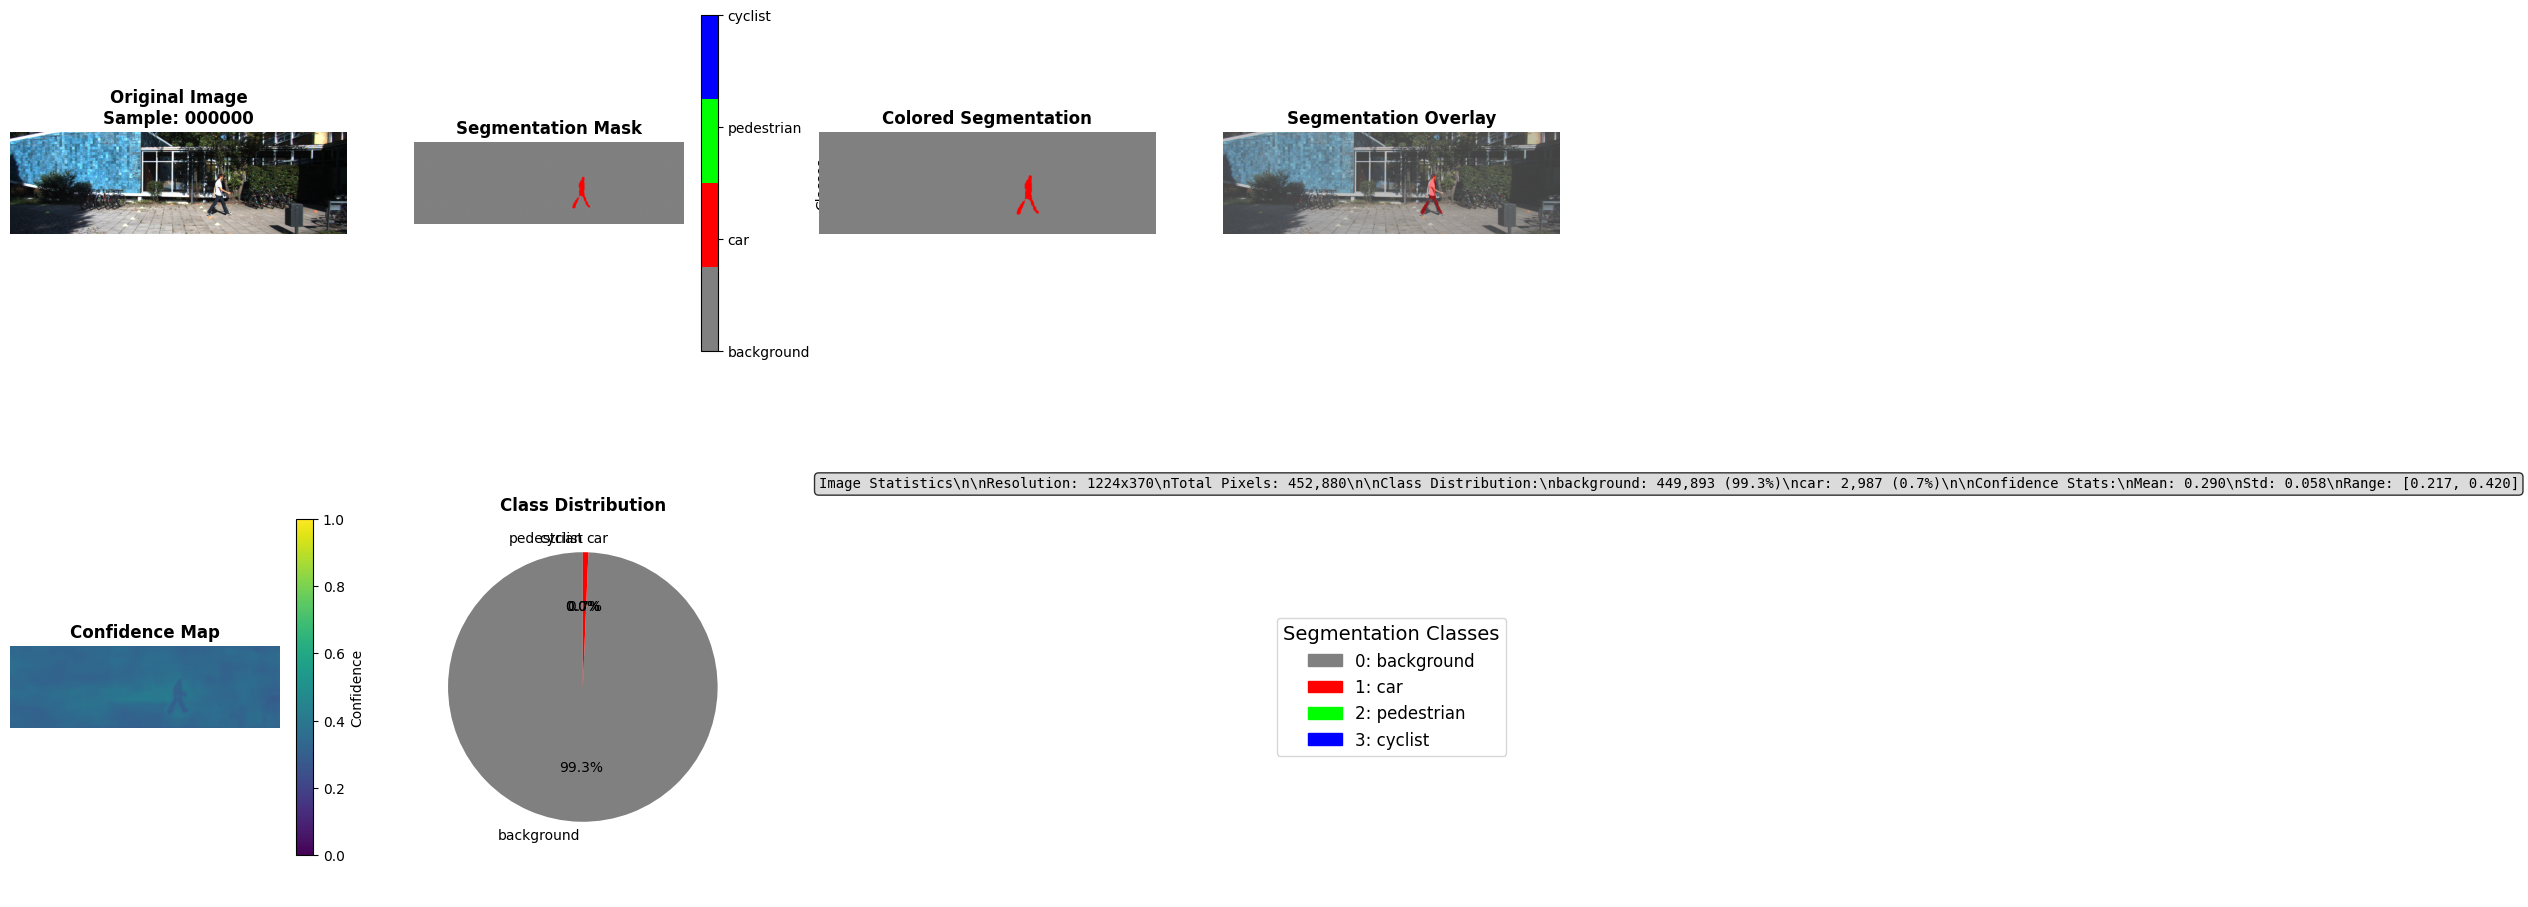

  💾 Saved: ../outputs/segmentation_analysis\segmentation_analysis_000000.png
  📊 Analysis complete for 000000
    background: 99.3%
    car: 0.7%
    Confidence: 0.290 ± 0.058
\nProcessing sample 2/10: 000001
  ✅ Image loaded: (375, 1242, 3)
  ✅ Segmentation completed


C:\Users\Caspe\AppData\Local\Temp\ipykernel_18328\2163687011.py:100: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


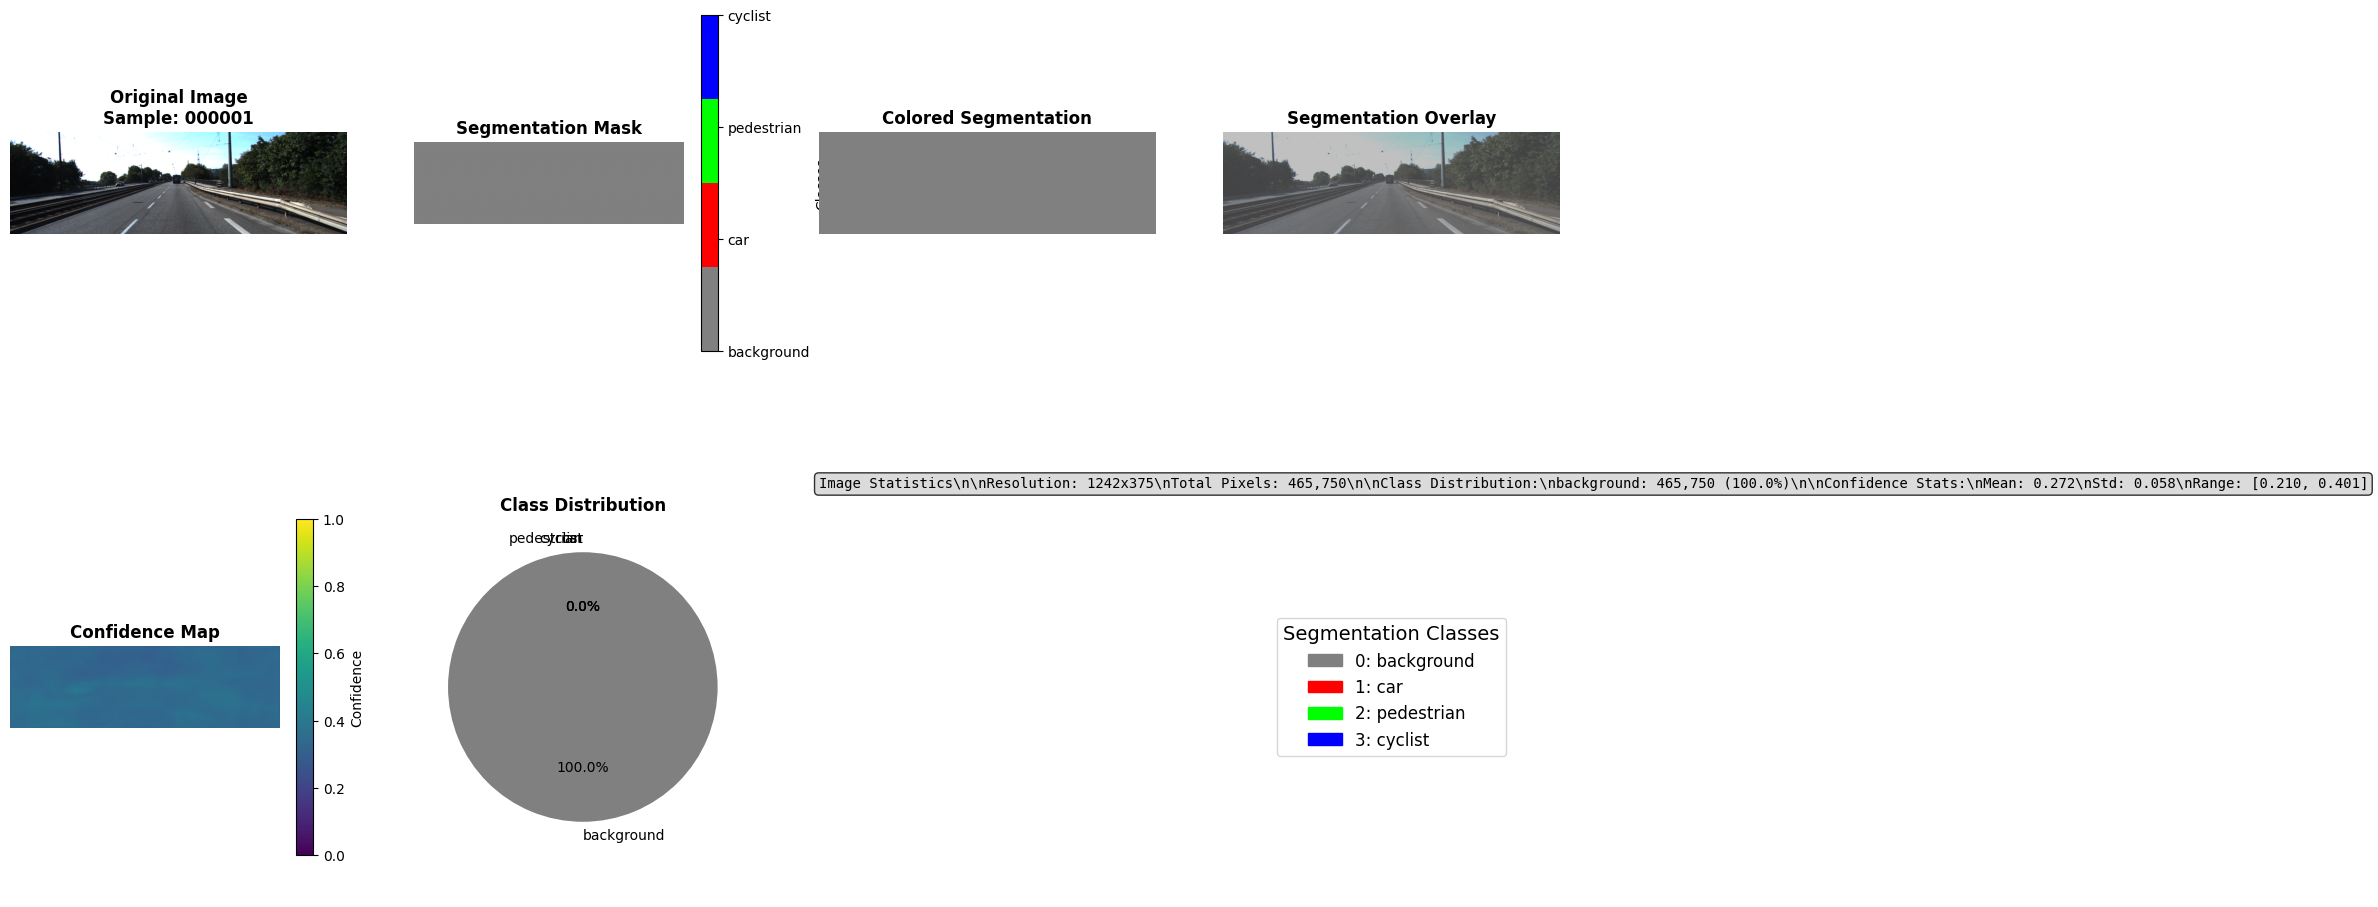

  💾 Saved: ../outputs/segmentation_analysis\segmentation_analysis_000001.png
  📊 Analysis complete for 000001
    background: 100.0%
    Confidence: 0.272 ± 0.058
\nProcessing sample 3/10: 000002
  ✅ Image loaded: (375, 1242, 3)
  ✅ Segmentation completed


C:\Users\Caspe\AppData\Local\Temp\ipykernel_18328\2163687011.py:100: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


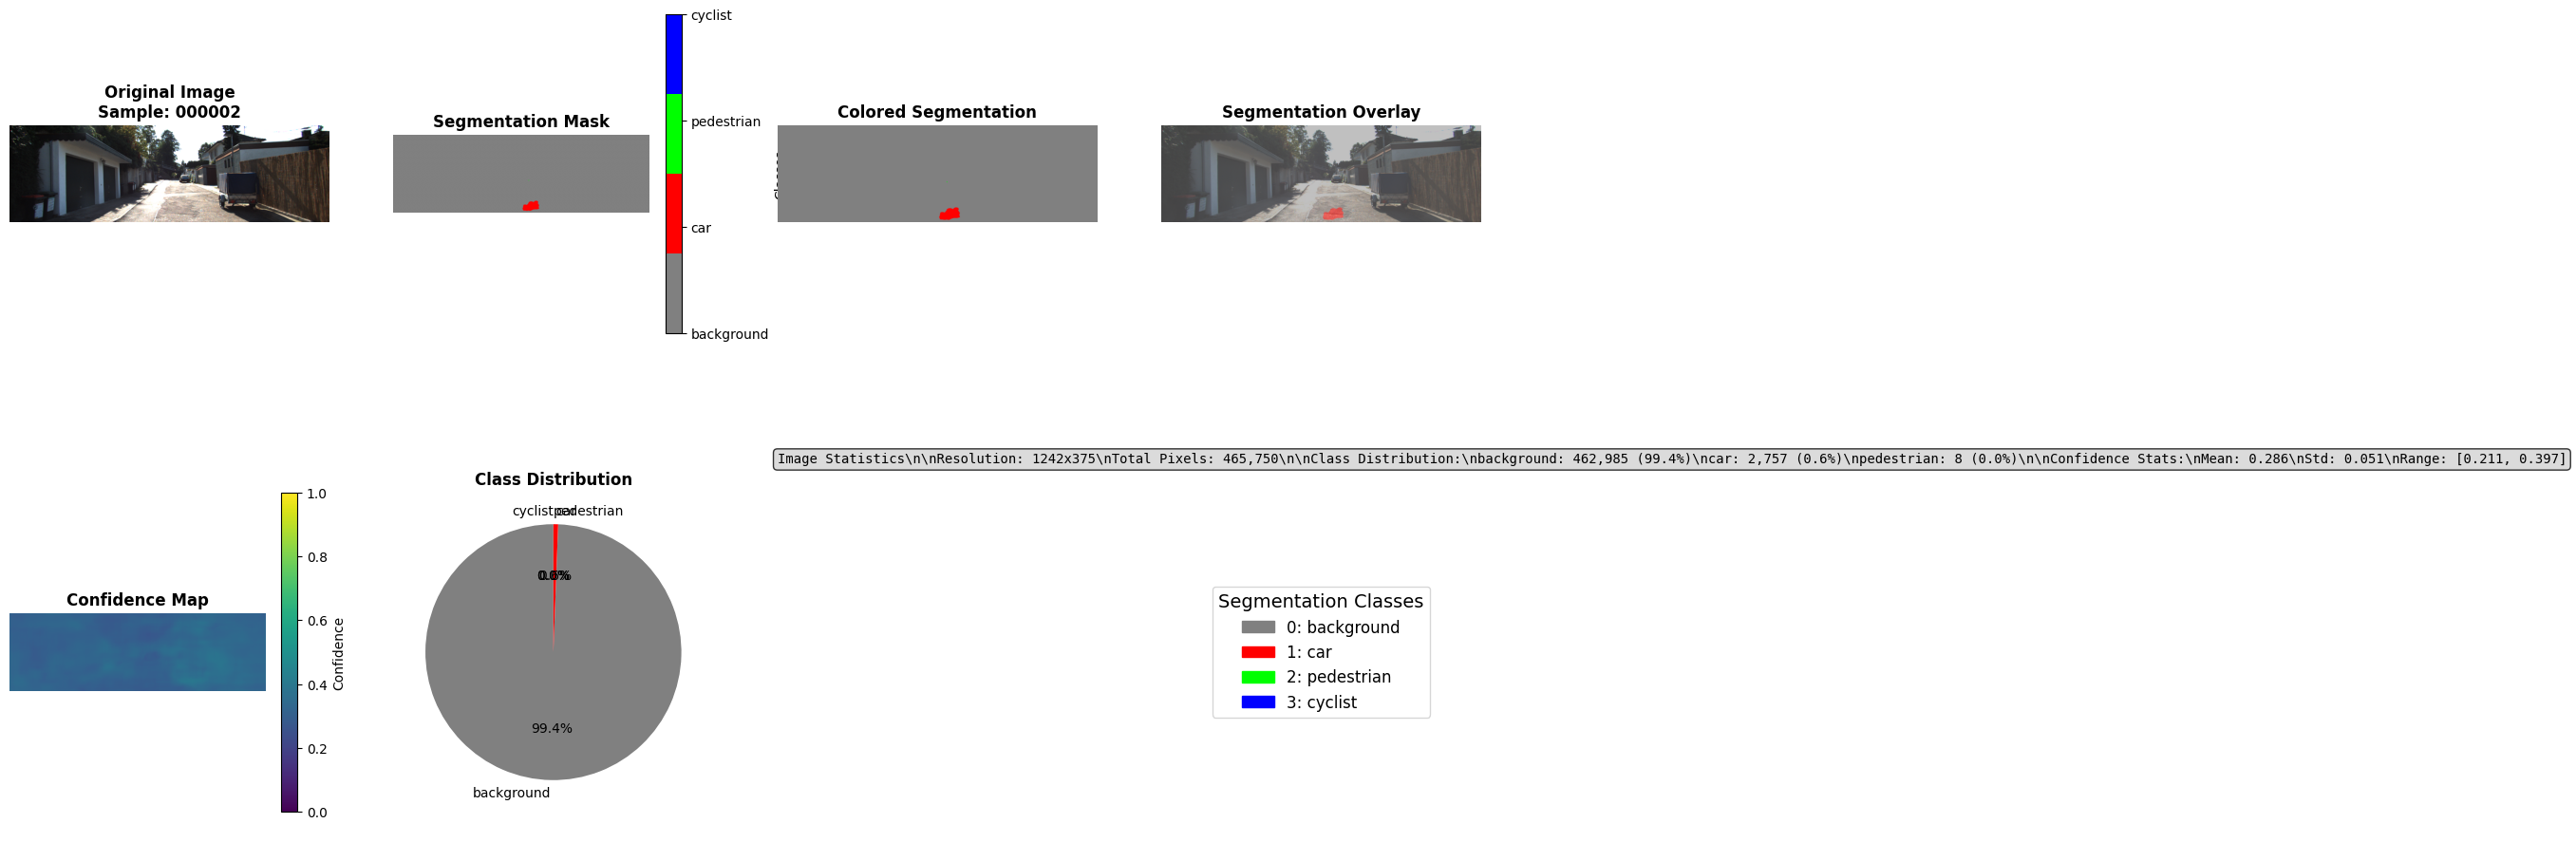

  💾 Saved: ../outputs/segmentation_analysis\segmentation_analysis_000002.png
  📊 Analysis complete for 000002
    background: 99.4%
    car: 0.6%
    pedestrian: 0.0%
    Confidence: 0.286 ± 0.051
\nProcessing sample 4/10: 000003
  ✅ Image loaded: (375, 1242, 3)
  ✅ Segmentation completed


C:\Users\Caspe\AppData\Local\Temp\ipykernel_18328\2163687011.py:100: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


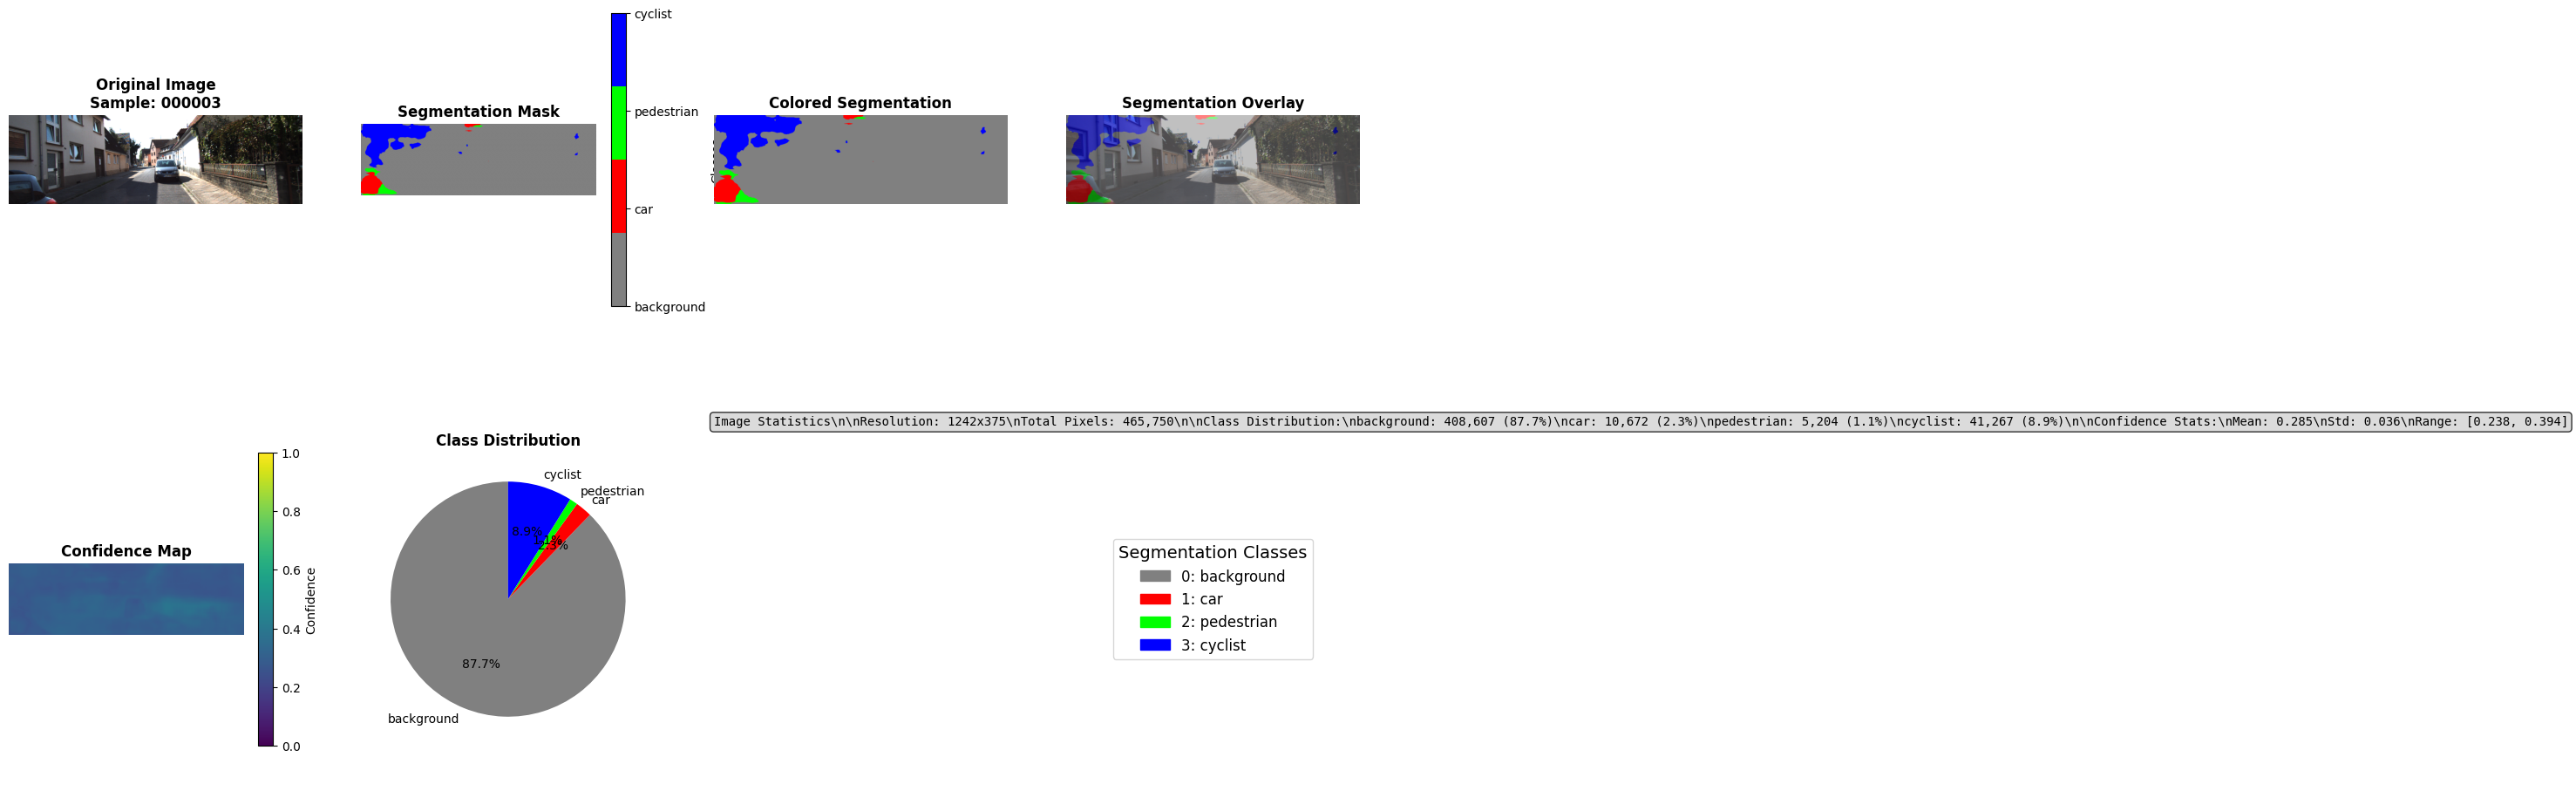

  💾 Saved: ../outputs/segmentation_analysis\segmentation_analysis_000003.png
  📊 Analysis complete for 000003
    background: 87.7%
    car: 2.3%
    pedestrian: 1.1%
    cyclist: 8.9%
    Confidence: 0.285 ± 0.036
\nProcessing sample 5/10: 000004
  ✅ Image loaded: (375, 1242, 3)
  ✅ Segmentation completed


C:\Users\Caspe\AppData\Local\Temp\ipykernel_18328\2163687011.py:100: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


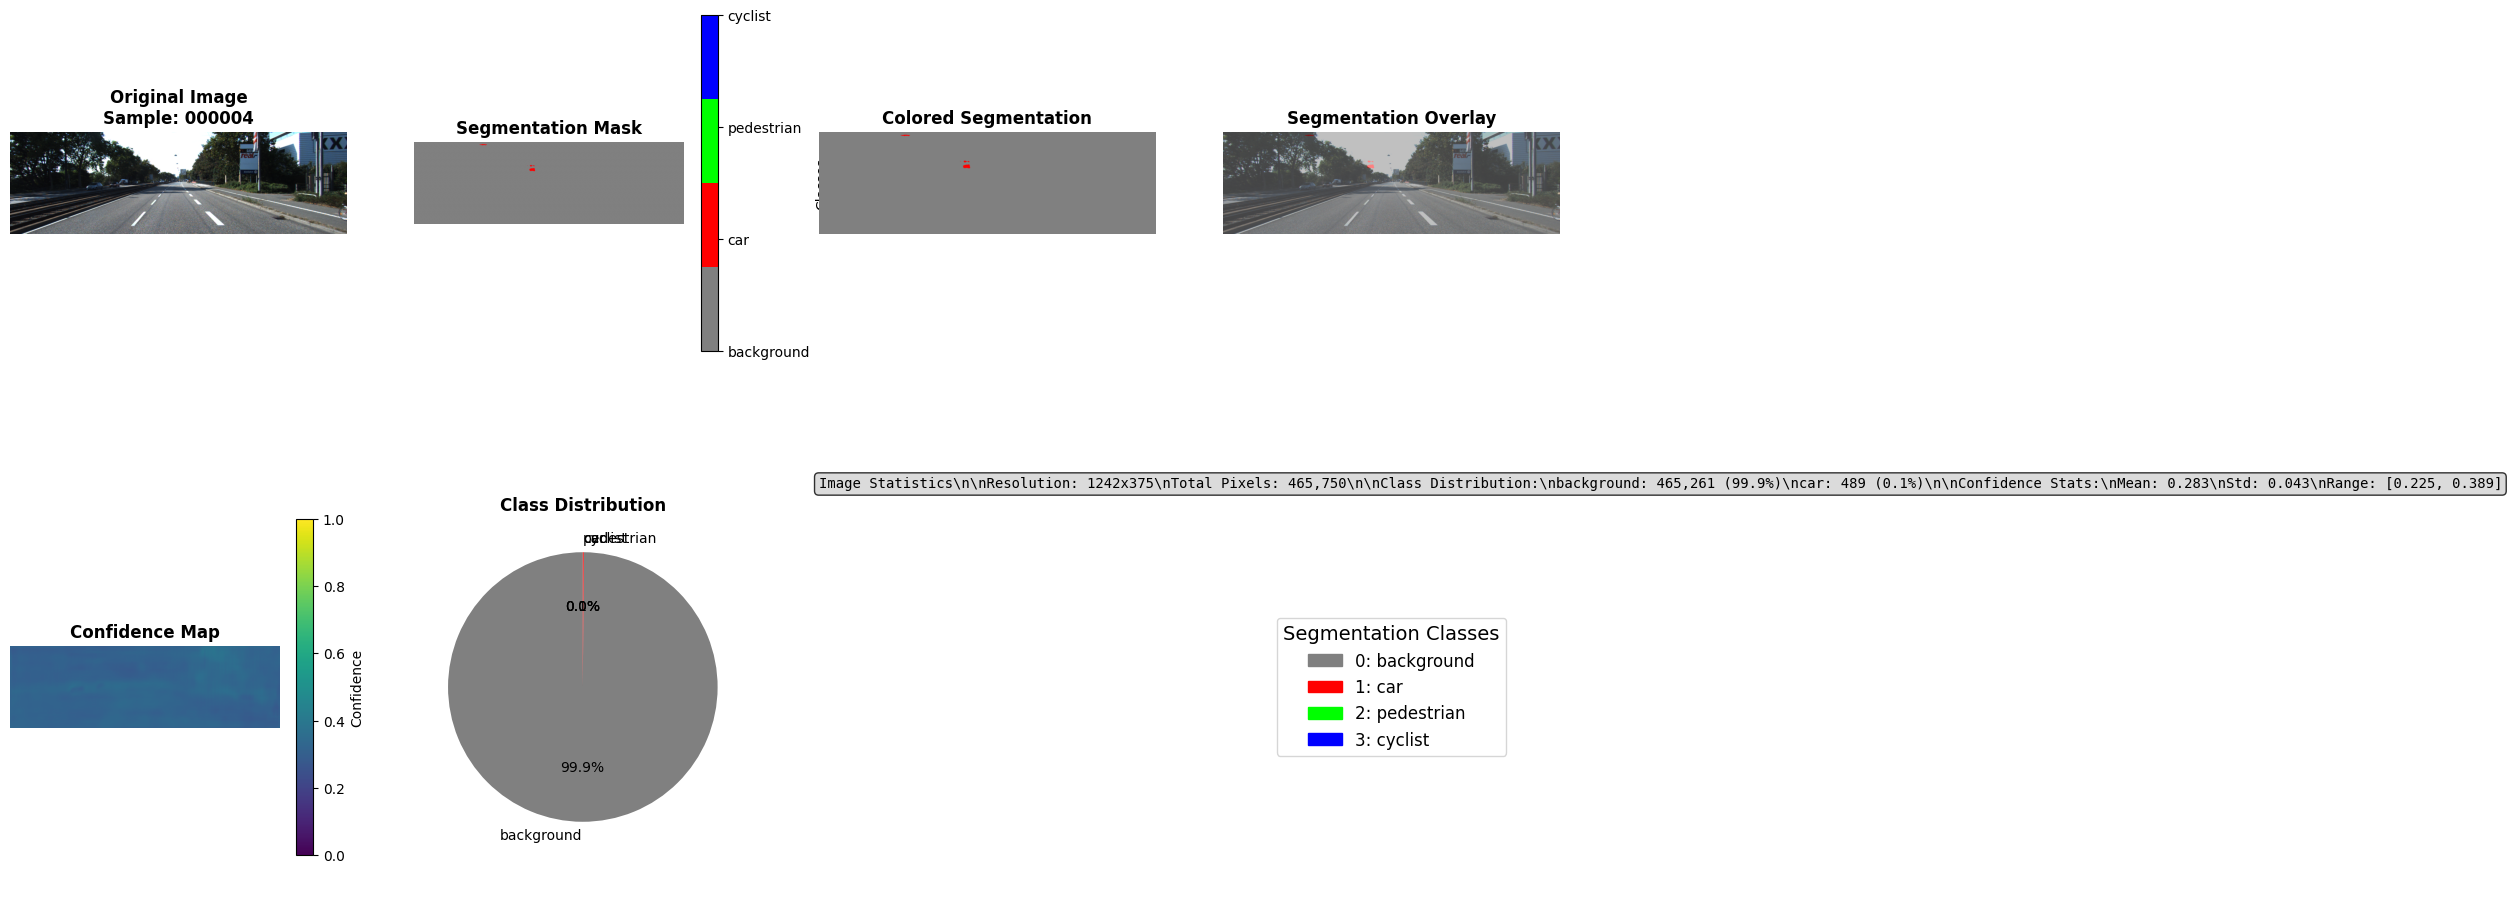

  💾 Saved: ../outputs/segmentation_analysis\segmentation_analysis_000004.png
  📊 Analysis complete for 000004
    background: 99.9%
    car: 0.1%
    Confidence: 0.283 ± 0.043
\nProcessing sample 6/10: 000005
  ✅ Image loaded: (375, 1242, 3)
  ✅ Segmentation completed


C:\Users\Caspe\AppData\Local\Temp\ipykernel_18328\2163687011.py:100: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


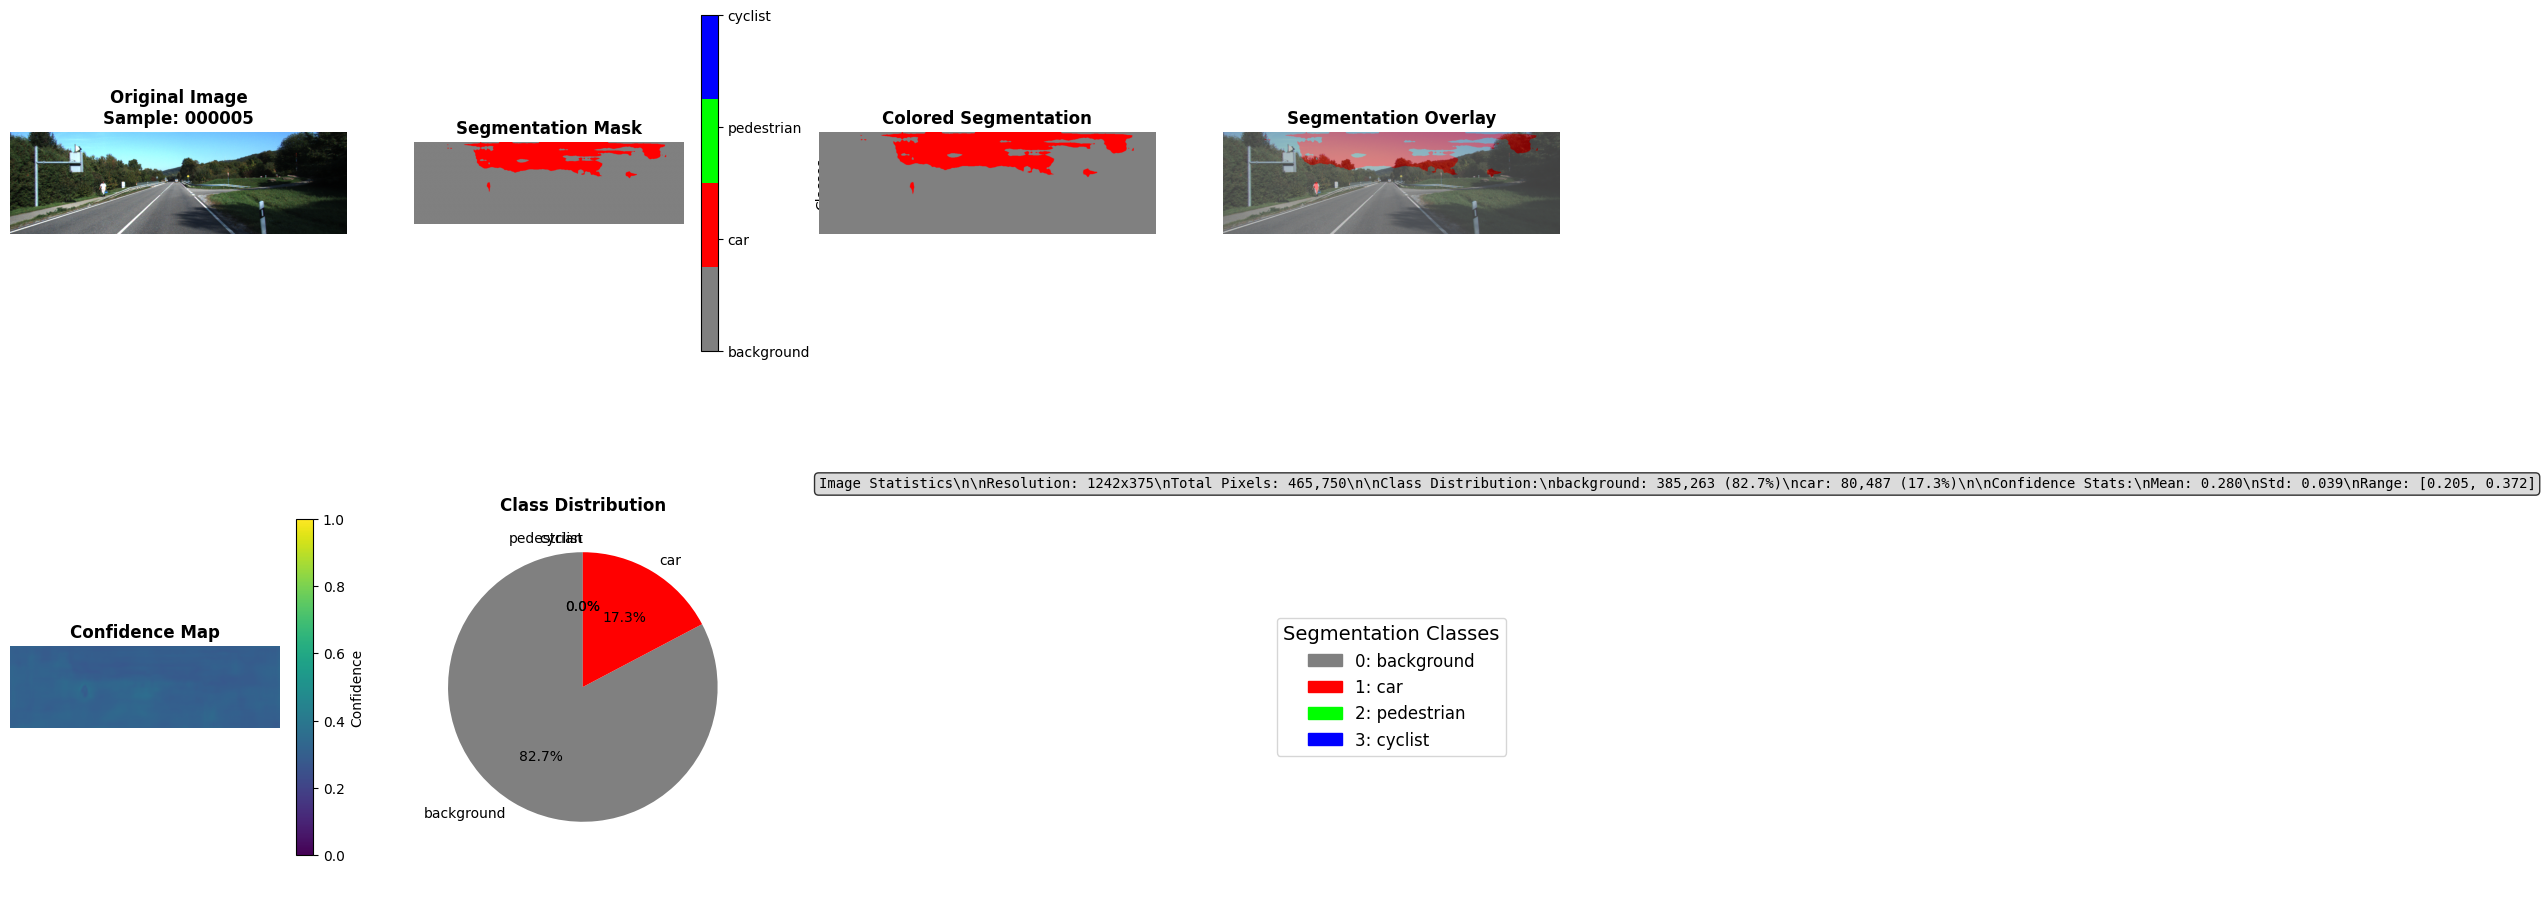

  💾 Saved: ../outputs/segmentation_analysis\segmentation_analysis_000005.png
  📊 Analysis complete for 000005
    background: 82.7%
    car: 17.3%
    Confidence: 0.280 ± 0.039
\nProcessing sample 7/10: 000006
  ✅ Image loaded: (374, 1238, 3)
  ✅ Segmentation completed


C:\Users\Caspe\AppData\Local\Temp\ipykernel_18328\2163687011.py:100: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


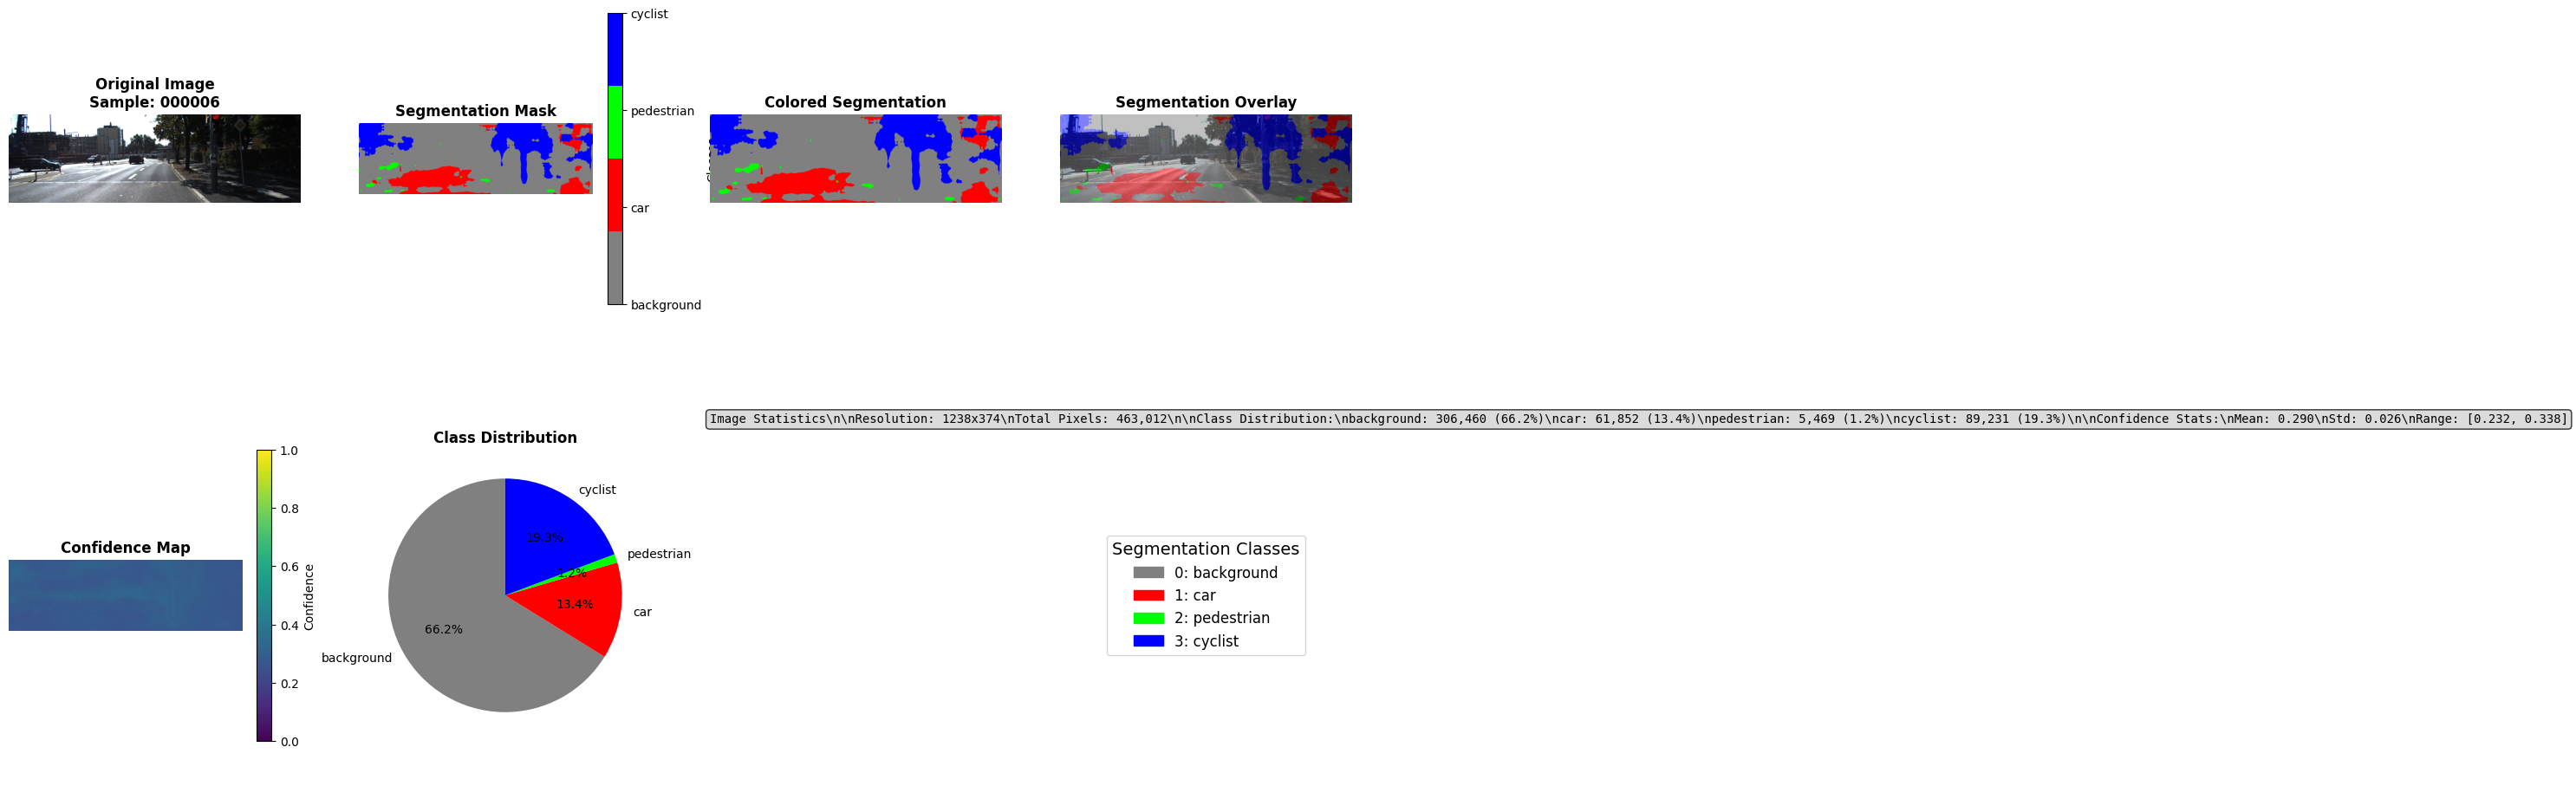

  💾 Saved: ../outputs/segmentation_analysis\segmentation_analysis_000006.png
  📊 Analysis complete for 000006
    background: 66.2%
    car: 13.4%
    pedestrian: 1.2%
    cyclist: 19.3%
    Confidence: 0.290 ± 0.026
\nProcessing sample 8/10: 000007
  ✅ Image loaded: (375, 1242, 3)
  ✅ Segmentation completed


C:\Users\Caspe\AppData\Local\Temp\ipykernel_18328\2163687011.py:100: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


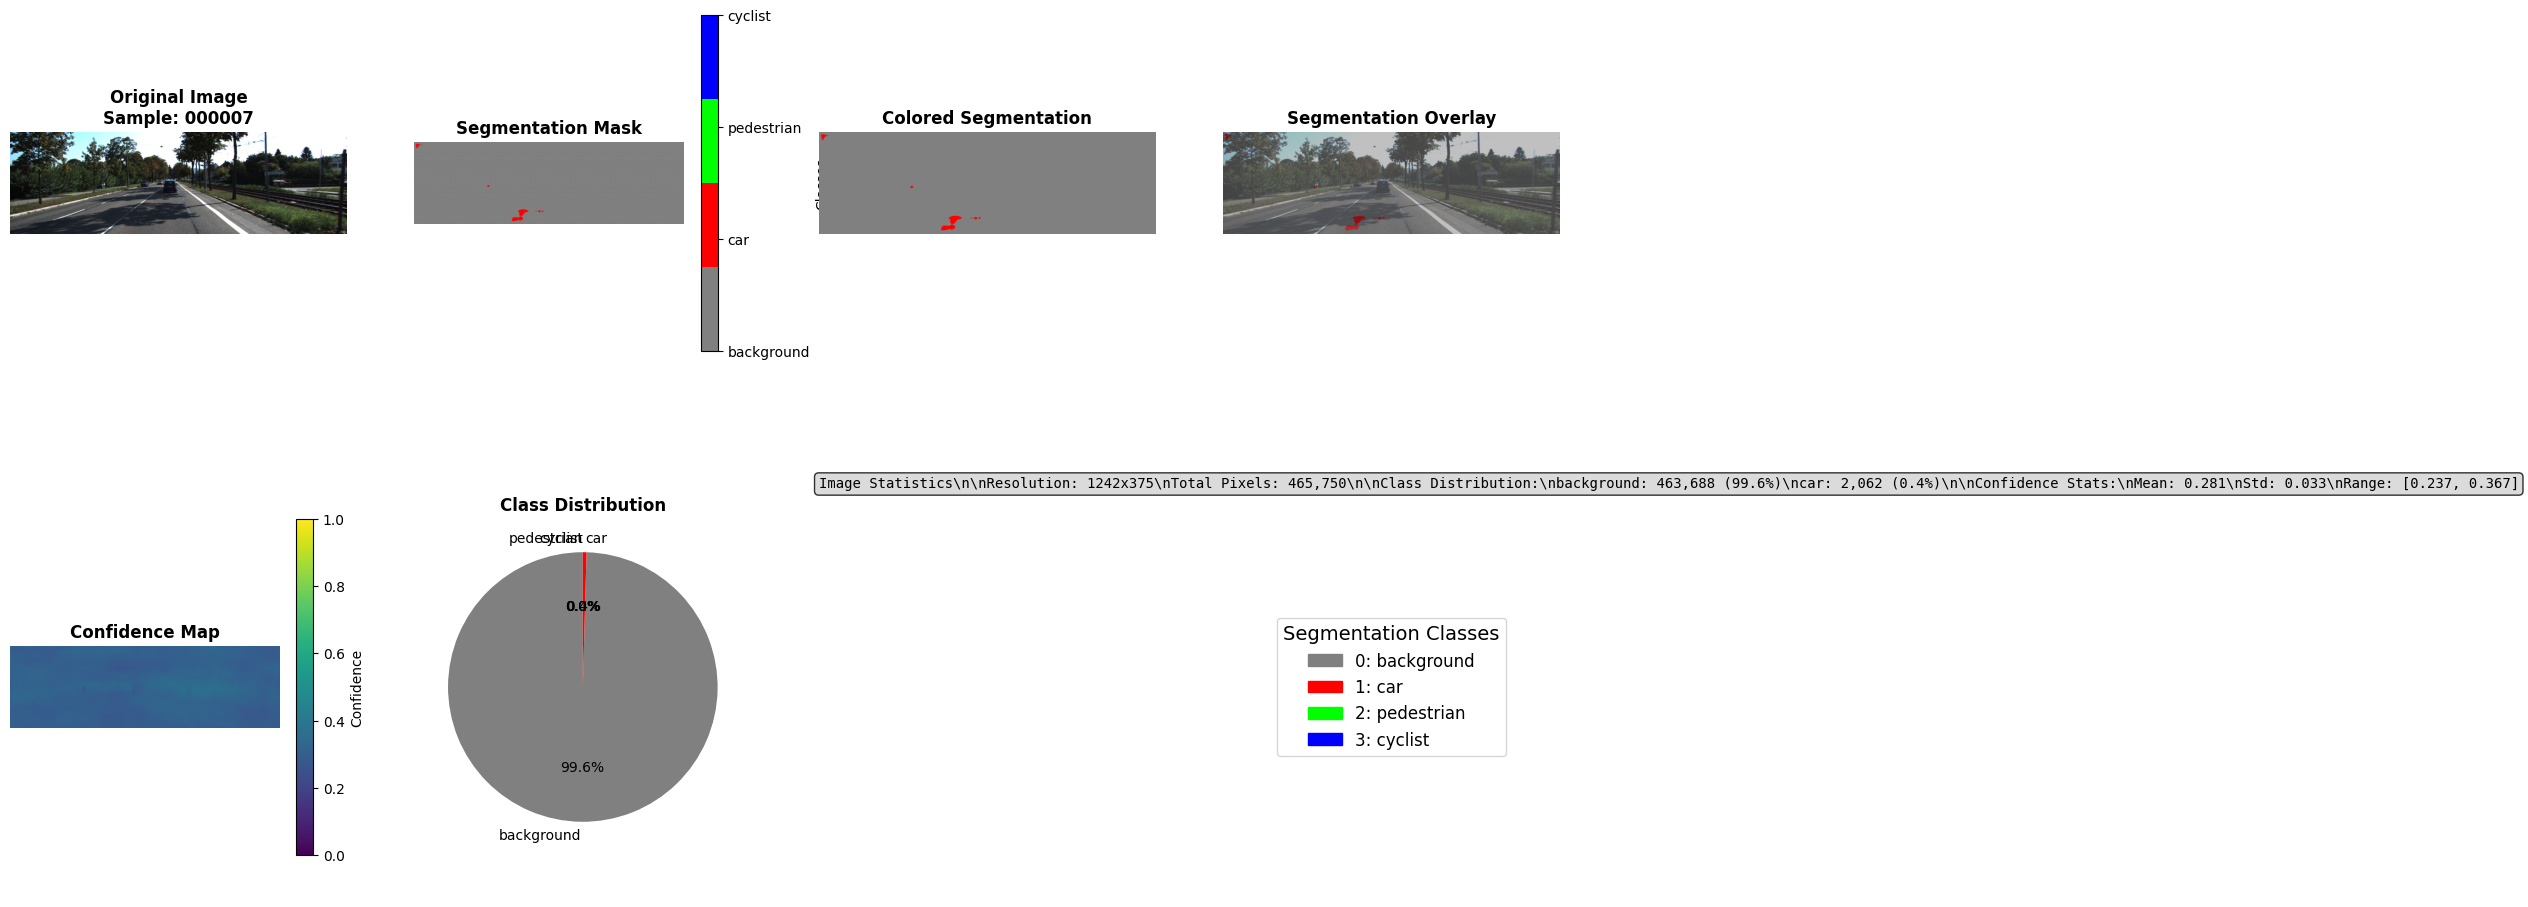

  💾 Saved: ../outputs/segmentation_analysis\segmentation_analysis_000007.png
  📊 Analysis complete for 000007
    background: 99.6%
    car: 0.4%
    Confidence: 0.281 ± 0.033
\nProcessing sample 9/10: 000008
  ✅ Image loaded: (375, 1242, 3)
  ✅ Segmentation completed


C:\Users\Caspe\AppData\Local\Temp\ipykernel_18328\2163687011.py:100: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


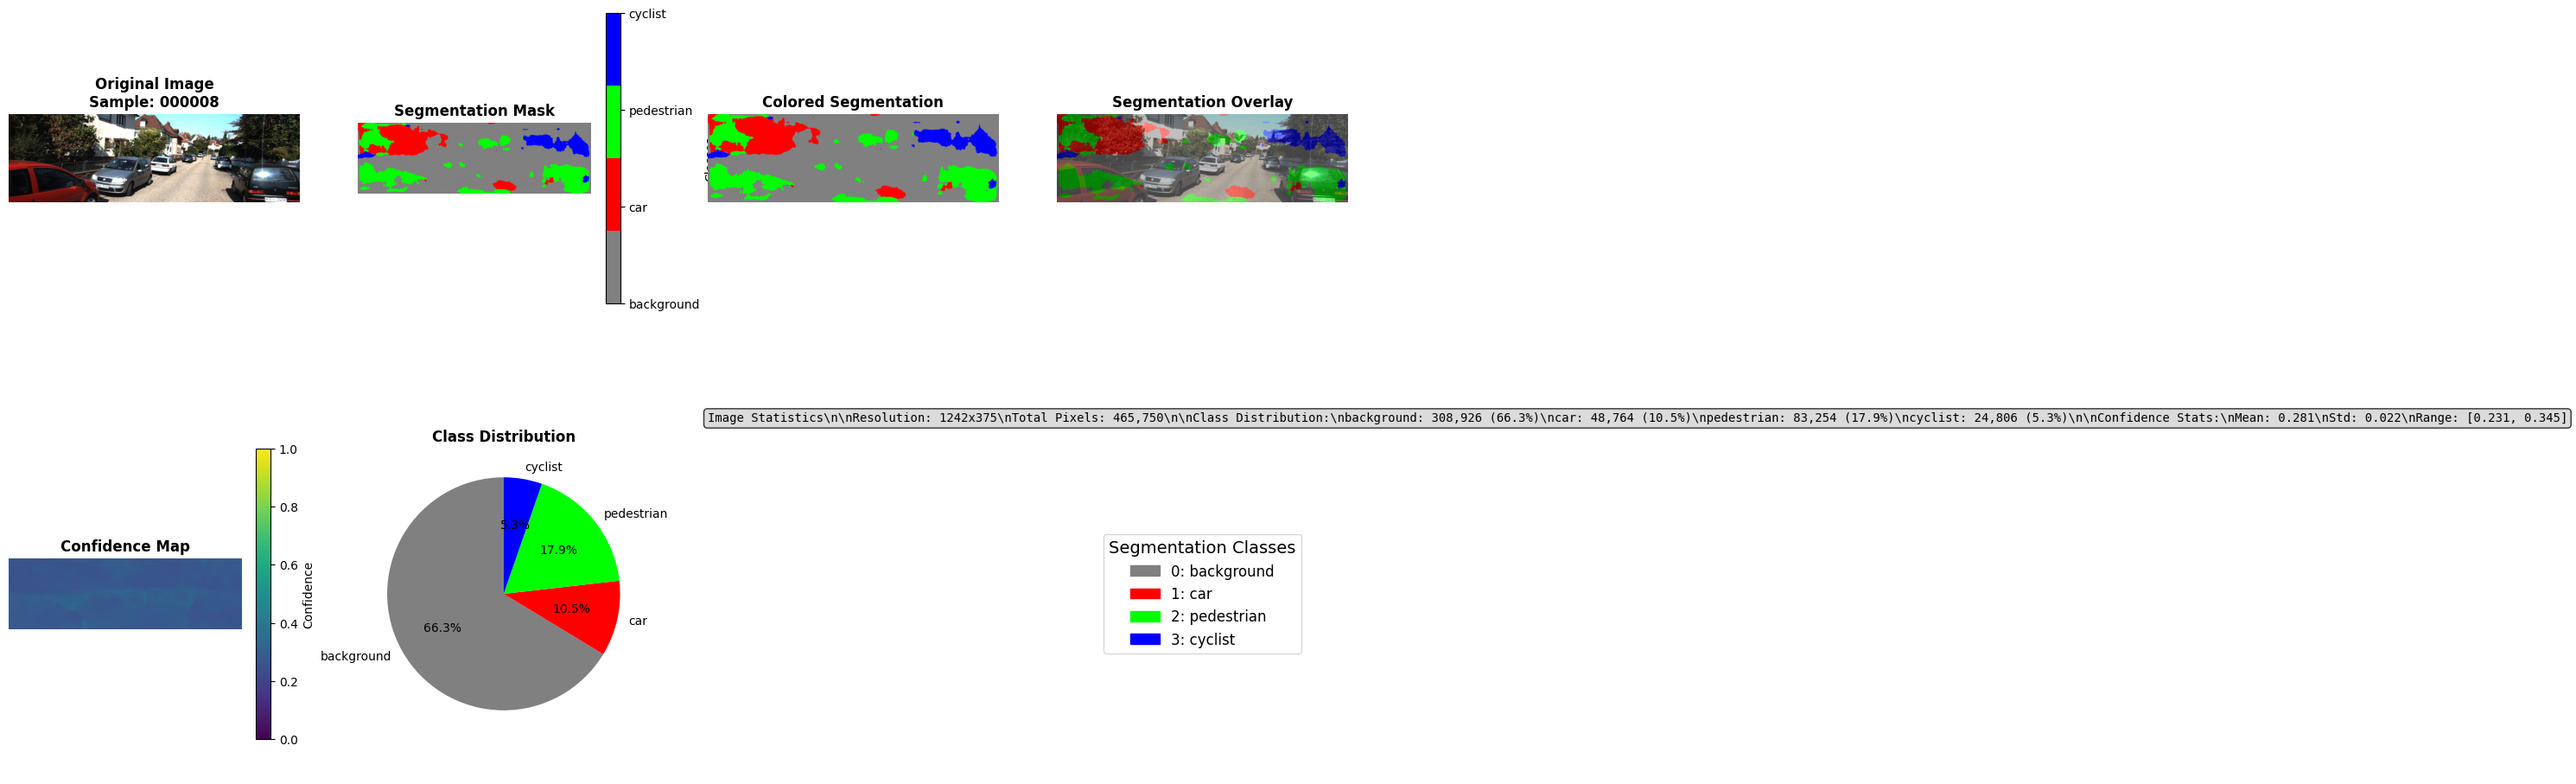

  💾 Saved: ../outputs/segmentation_analysis\segmentation_analysis_000008.png
  📊 Analysis complete for 000008
    background: 66.3%
    car: 10.5%
    pedestrian: 17.9%
    cyclist: 5.3%
    Confidence: 0.281 ± 0.022
\nProcessing sample 10/10: 000009
  ✅ Image loaded: (375, 1242, 3)
  ✅ Segmentation completed


C:\Users\Caspe\AppData\Local\Temp\ipykernel_18328\2163687011.py:100: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


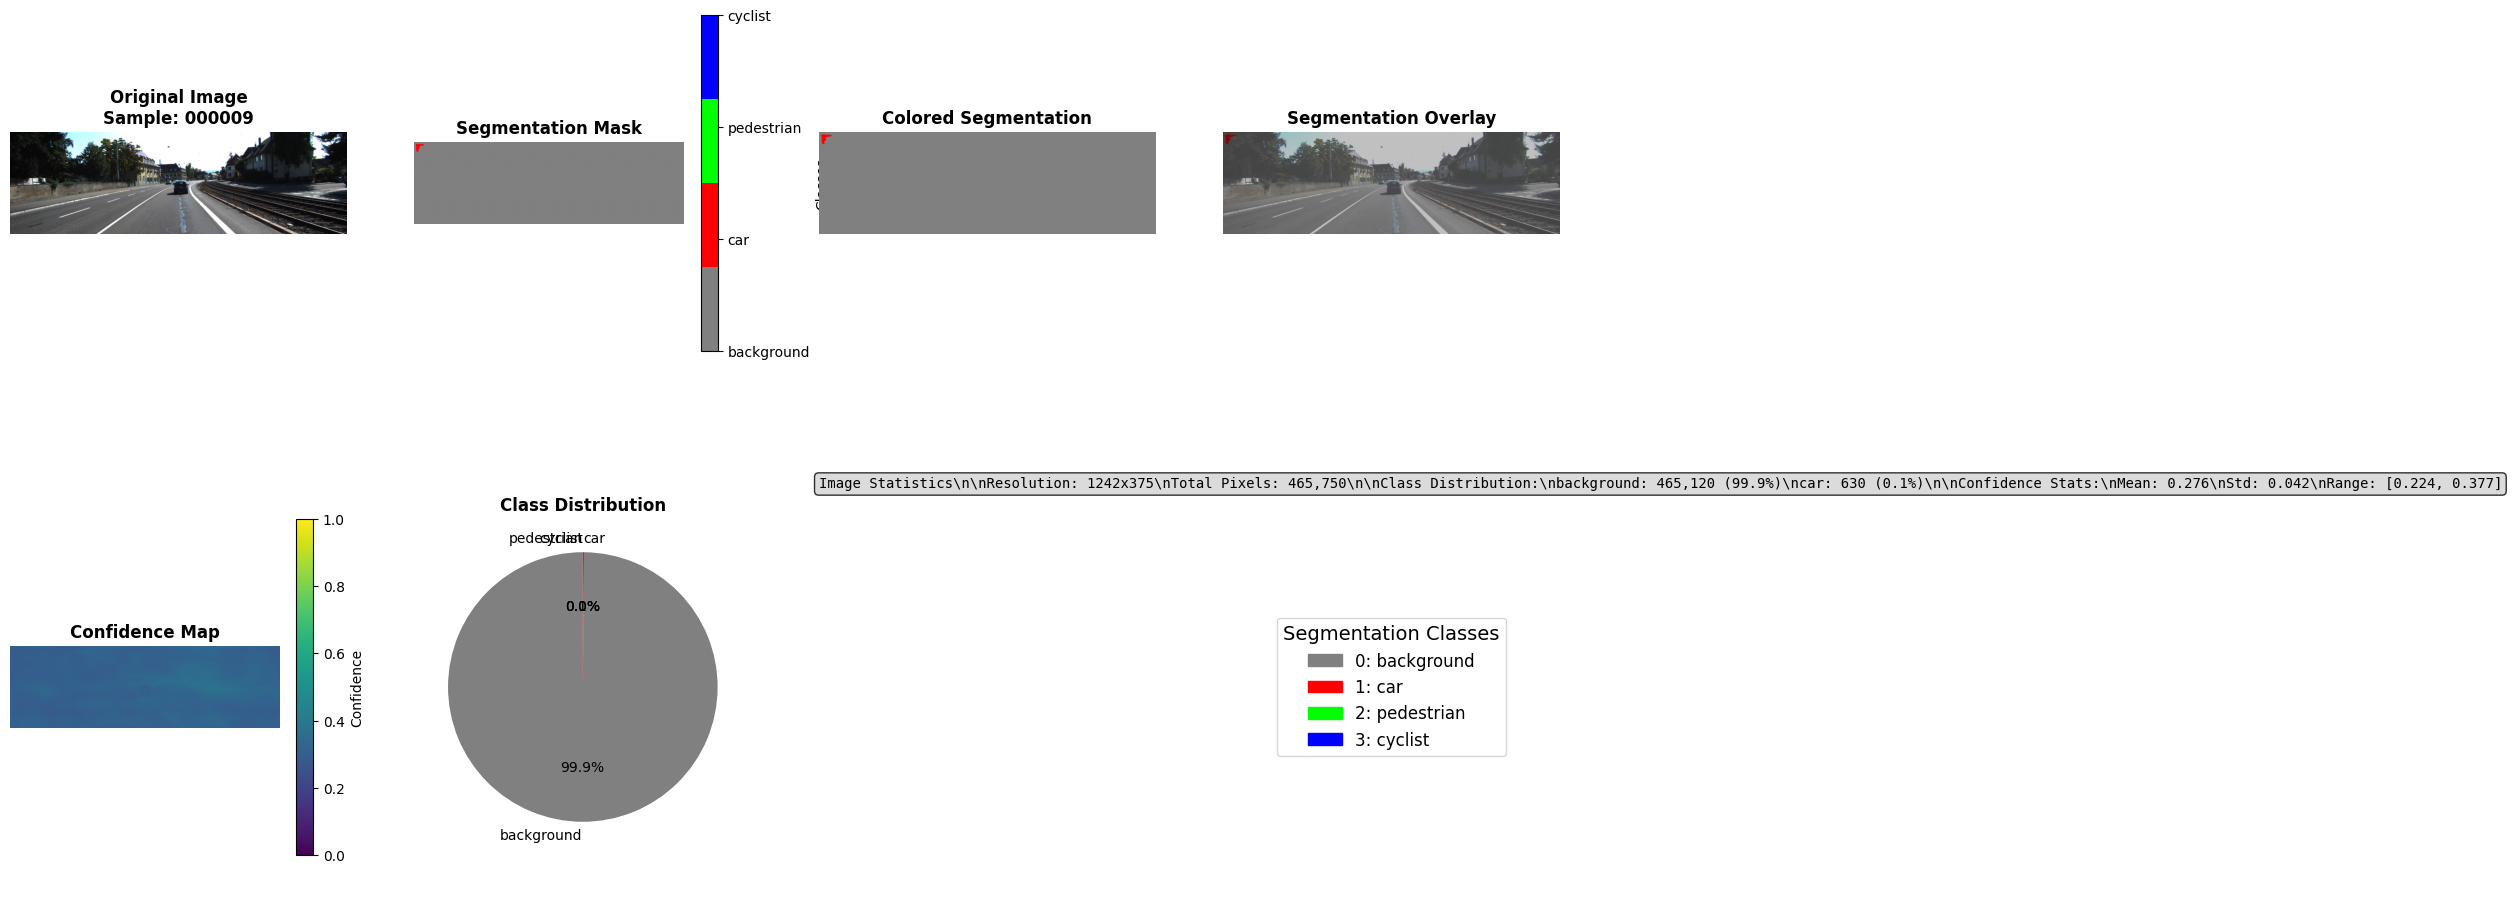

  💾 Saved: ../outputs/segmentation_analysis\segmentation_analysis_000009.png
  📊 Analysis complete for 000009
    background: 99.9%
    car: 0.1%
    Confidence: 0.276 ± 0.042
\n============================================================
Analysis complete! Processed 10 samples successfully.


In [8]:
# Main analysis loop
results_summary = []
confidence_maps = []
sample_ids = []

print("Starting segmentation analysis...")
print("=" * 60)

for i, image_filename in enumerate(available_images[:NUM_SAMPLES_TO_ANALYZE]):
    # Extract sample ID
    sample_id = image_filename.replace('.png', '')
    sample_ids.append(sample_id)
    
    print(f"\\nProcessing sample {i+1}/{NUM_SAMPLES_TO_ANALYZE}: {sample_id}")
    
    try:
        # Load and preprocess image
        image_path = os.path.join(training_image_dir, image_filename)
        original_image = load_and_preprocess_image(sample_id, data_loader)[0]
        
        if original_image is None:
            print(f"  ❌ Failed to load image: {image_filename}")
            continue
            
        print(f"  ✅ Image loaded: {original_image.shape}")
        
        # Perform segmentation
        with torch.no_grad():
            # Convert to tensor and add batch dimension
            image_tensor = torch.from_numpy(original_image.transpose(2, 0, 1)).float() / 255.0
            image_tensor = image_tensor.unsqueeze(0).to(device)
            
            # Get predictions
            outputs = segmentation_model.model(image_tensor)
            # Convert to numpy
            predictions = torch.argmax(outputs['out'], dim=1).squeeze().cpu().numpy()
            probabilities = torch.softmax(outputs['out'], dim=1).squeeze().cpu().numpy()
            
            # Calculate confidence (max probability)
            confidence = np.max(probabilities, axis=0)
            confidence_maps.append(confidence)
            
        print(f"  ✅ Segmentation completed")
        
        # Calculate statistics
        stats = analyze_segmentation_stats(predictions, probabilities, CLASS_NAMES)
        results_summary.append({
            'sample_id': sample_id,
            'stats': stats
        })
        
        # Create visualization
        fig = visualize_single_sample(
            sample_id=sample_id,
            original_image=original_image,
            predictions=predictions,
            probabilities=probabilities,
            confidence=confidence,
            stats=stats,
            class_names=CLASS_NAMES,
            class_colors=color_array,
        )
        
        # Save visualization if requested
        if SAVE_RESULTS:
            output_path = os.path.join(OUTPUT_DIR, f"segmentation_analysis_{sample_id}.png")
            fig.savefig(output_path, dpi=150, bbox_inches='tight')
            plt.close(fig)  # Close to save memory
            print(f"  💾 Saved: {output_path}")
        
        print(f"  📊 Analysis complete for {sample_id}")
        
        # Display class distribution
        for class_name in CLASS_NAMES:
            if class_name in stats:
                percentage = stats[class_name]['percentage']
                print(f"    {class_name}: {percentage:.1f}%")
        
        # Display confidence stats
        conf_stats = stats['confidence']
        print(f"    Confidence: {conf_stats['mean']:.3f} ± {conf_stats['std']:.3f}")
        
    except Exception as e:
        print(f"  ❌ Error processing {sample_id}: {str(e)}")
        continue

print("\\n" + "=" * 60)
print(f"Analysis complete! Processed {len(results_summary)} samples successfully.")

## Summary Analysis and Insights

Let's analyze the overall results across all processed samples:

📊 SEGMENTATION ANALYSIS SUMMARY
\n📈 OVERALL CLASS DISTRIBUTION:
------------------------------
background  :  90.1% ± 13.2% (range: 66.2% - 100.0%)
car         :   4.5% ±  6.2% (range:  0.0% - 17.3%)
pedestrian  :   2.0% ±  5.3% (range:  0.0% - 17.9%)
cyclist     :   3.3% ±  6.1% (range:  0.0% - 19.3%)
\n🎯 CONFIDENCE ANALYSIS:
-------------------------
Mean Confidence: 0.282 ± 0.005
Range: 0.272 - 0.290


C:\Users\Caspe\AppData\Local\Temp\ipykernel_18328\1514656652.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax1.boxplot(class_data, labels=CLASS_NAMES, patch_artist=True)


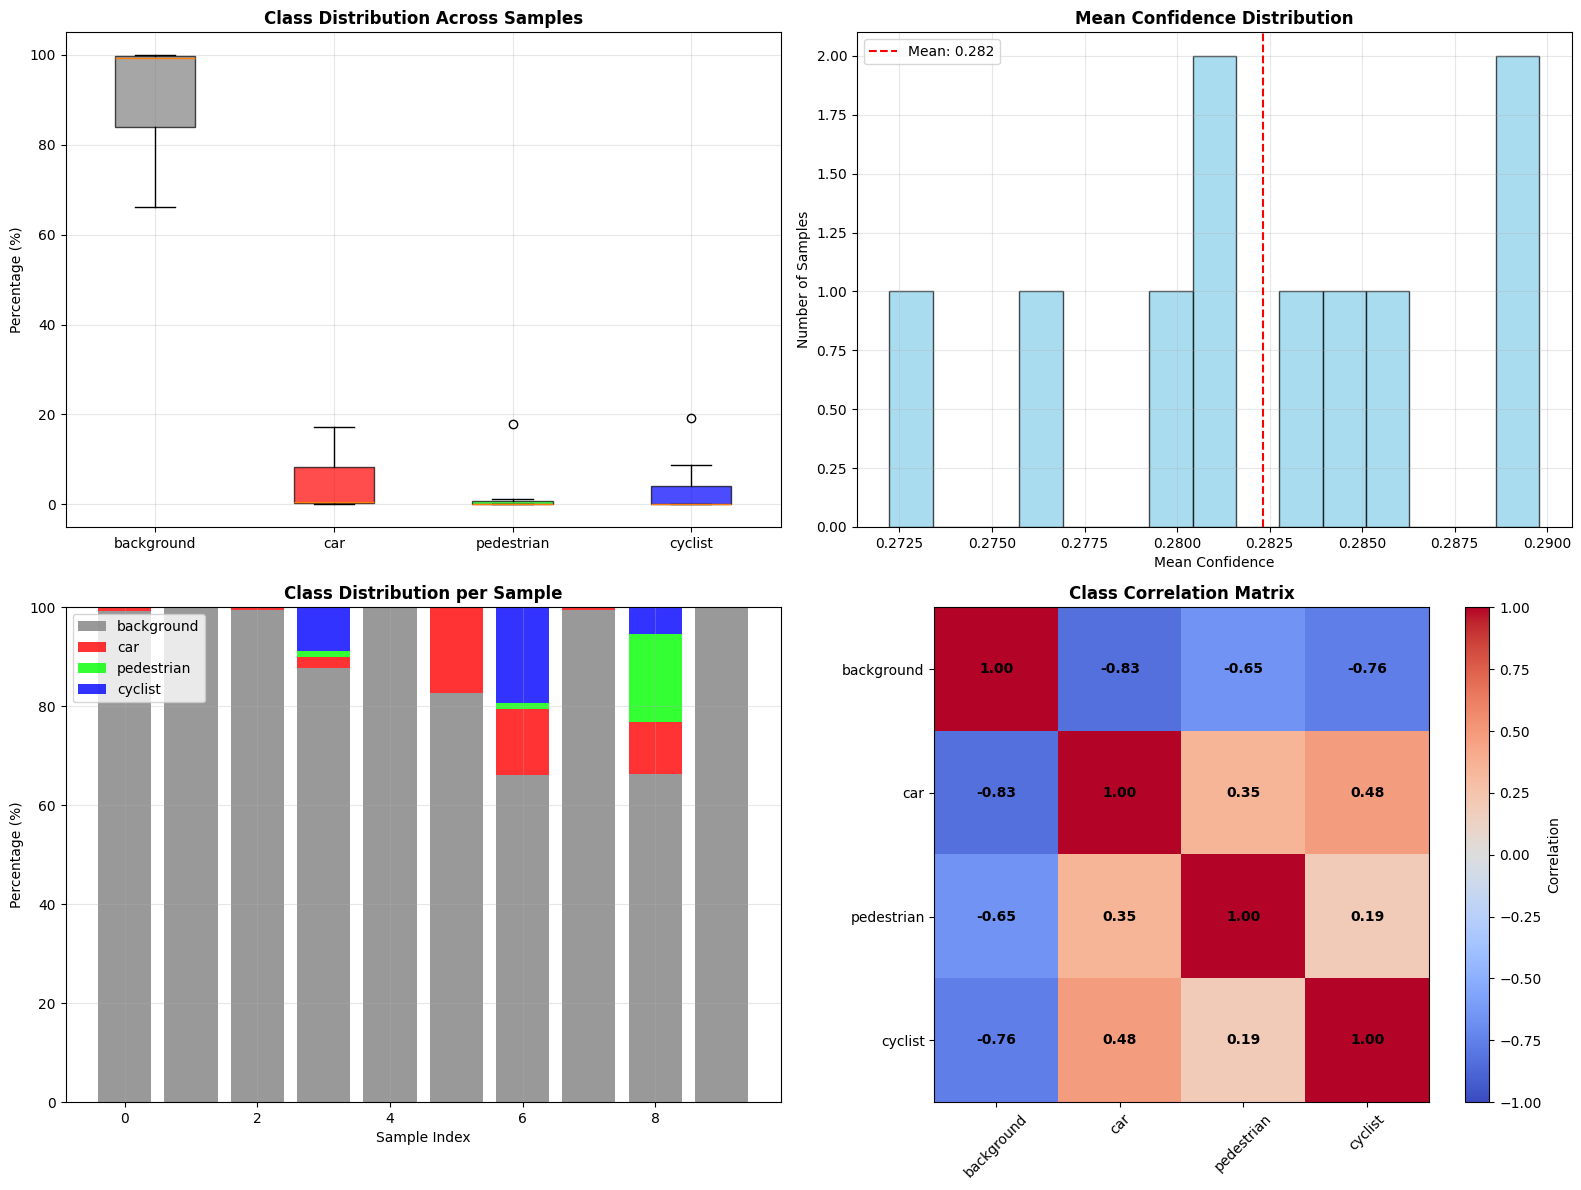

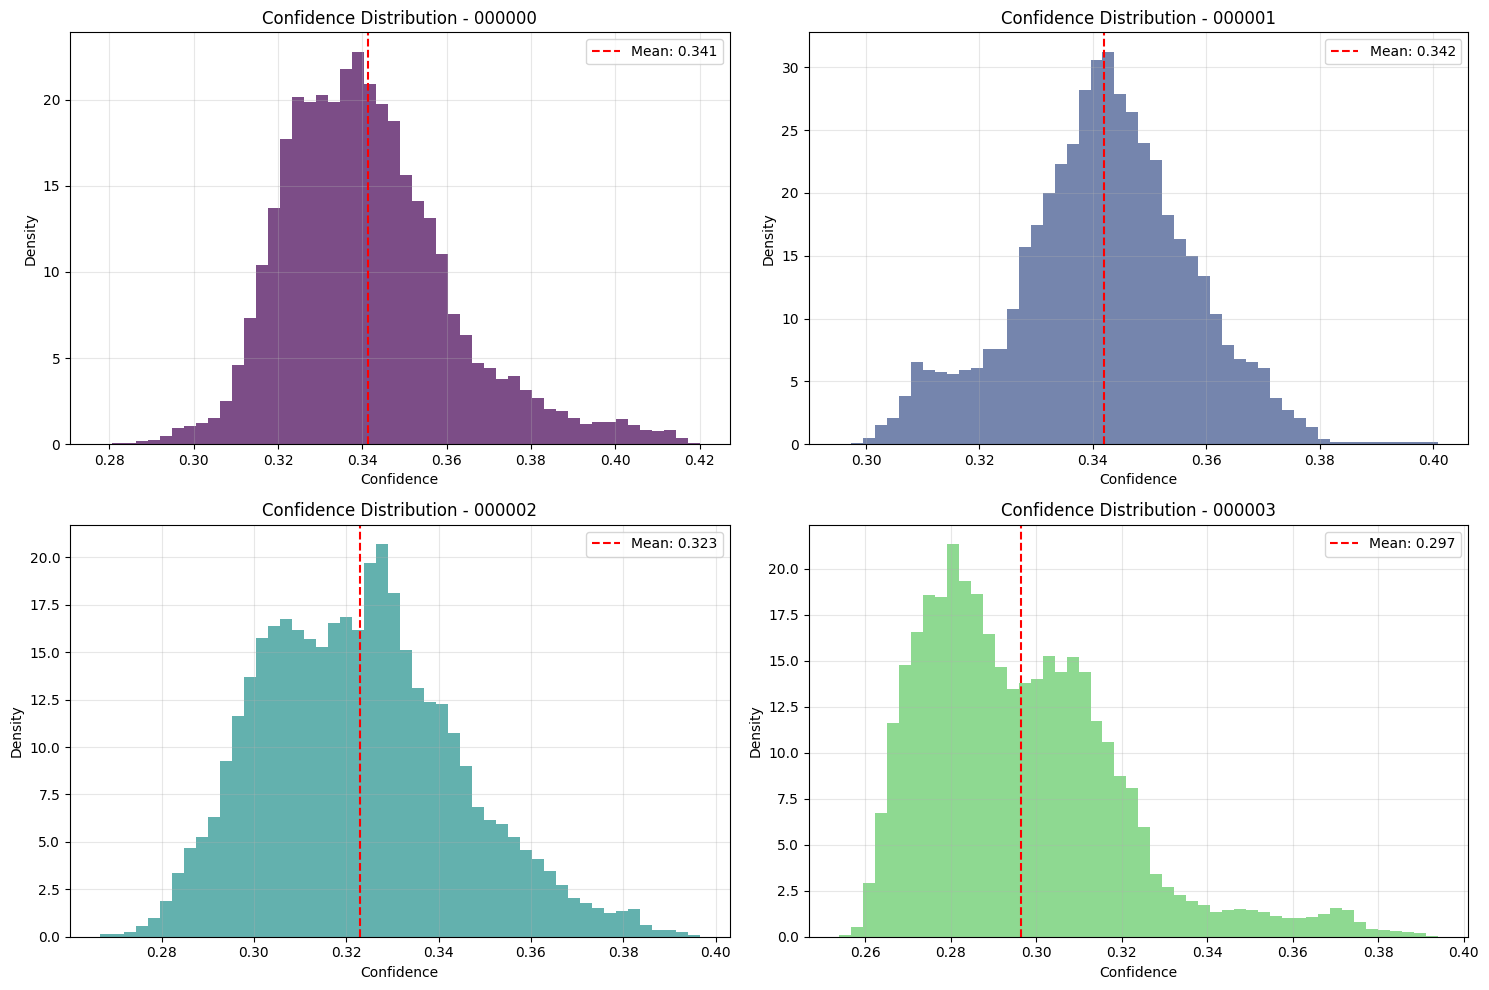

In [9]:
# Aggregate statistics across all samples
if results_summary:
    print("📊 SEGMENTATION ANALYSIS SUMMARY")
    print("=" * 50)
    
    # Aggregate class statistics
    aggregated_stats = {class_name: [] for class_name in CLASS_NAMES}
    confidence_stats = []
    
    for result in results_summary:
        stats = result['stats']
        
        # Collect class percentages
        for class_name in CLASS_NAMES:
            if class_name in stats:
                aggregated_stats[class_name].append(stats[class_name]['percentage'])
            else:
                aggregated_stats[class_name].append(0.0)
        
        # Collect confidence stats
        confidence_stats.append(stats['confidence']['mean'])
    
    # Calculate overall statistics
    print(f"\\n📈 OVERALL CLASS DISTRIBUTION:")
    print("-" * 30)
    
    overall_class_stats = {}
    for class_name in CLASS_NAMES:
        percentages = aggregated_stats[class_name]
        if percentages:
            mean_pct = np.mean(percentages)
            std_pct = np.std(percentages)
            min_pct = np.min(percentages)
            max_pct = np.max(percentages)
            
            overall_class_stats[class_name] = {
                'mean': mean_pct,
                'std': std_pct,
                'min': min_pct,
                'max': max_pct
            }
            
            print(f"{class_name:12}: {mean_pct:5.1f}% ± {std_pct:4.1f}% "
                  f"(range: {min_pct:4.1f}% - {max_pct:4.1f}%)")
    
    print(f"\\n🎯 CONFIDENCE ANALYSIS:")
    print("-" * 25)
    mean_confidence = np.mean(confidence_stats)
    std_confidence = np.std(confidence_stats)
    min_confidence = np.min(confidence_stats)
    max_confidence = np.max(confidence_stats)
    
    print(f"Mean Confidence: {mean_confidence:.3f} ± {std_confidence:.3f}")
    print(f"Range: {min_confidence:.3f} - {max_confidence:.3f}")
    
    # Create summary plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Class distribution box plot
    ax1 = axes[0, 0]
    class_data = [aggregated_stats[name] for name in CLASS_NAMES]
    colors_norm = [color/255.0 for color in color_array]
    
    box_plot = ax1.boxplot(class_data, labels=CLASS_NAMES, patch_artist=True)
    for patch, color in zip(box_plot['boxes'], colors_norm):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax1.set_title("Class Distribution Across Samples", fontweight='bold')
    ax1.set_ylabel("Percentage (%)")
    ax1.grid(True, alpha=0.3)
    
    # 2. Confidence distribution
    ax2 = axes[0, 1]
    ax2.hist(confidence_stats, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.axvline(mean_confidence, color='red', linestyle='--', 
                label=f'Mean: {mean_confidence:.3f}')
    ax2.set_title("Mean Confidence Distribution", fontweight='bold')
    ax2.set_xlabel("Mean Confidence")
    ax2.set_ylabel("Number of Samples")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Sample-wise class distribution
    ax3 = axes[1, 0]
    sample_indices = range(len(results_summary))
    bottom = np.zeros(len(sample_indices))
    
    for i, class_name in enumerate(CLASS_NAMES):
        percentages = aggregated_stats[class_name]
        color = color_array[i] / 255.0
        ax3.bar(sample_indices, percentages, bottom=bottom, 
                label=class_name, color=color, alpha=0.8)
        bottom += percentages
    
    ax3.set_title("Class Distribution per Sample", fontweight='bold')
    ax3.set_xlabel("Sample Index")
    ax3.set_ylabel("Percentage (%)")
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Class correlation matrix
    ax4 = axes[1, 1]
    class_matrix = np.array([aggregated_stats[name] for name in CLASS_NAMES])
    correlation_matrix = np.corrcoef(class_matrix)
    
    im = ax4.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    ax4.set_xticks(range(len(CLASS_NAMES)))
    ax4.set_yticks(range(len(CLASS_NAMES)))
    ax4.set_xticklabels(CLASS_NAMES, rotation=45)
    ax4.set_yticklabels(CLASS_NAMES)
    ax4.set_title("Class Correlation Matrix", fontweight='bold')
    
    # Add correlation values to the plot
    for i in range(len(CLASS_NAMES)):
        for j in range(len(CLASS_NAMES)):
            text = ax4.text(j, i, f'{correlation_matrix[i, j]:.2f}',
                           ha="center", va="center", color="black", fontweight='bold')
    
    plt.colorbar(im, ax=ax4, label='Correlation')
    
    plt.tight_layout()
    plt.show()
    
    # Plot confidence histograms for first few samples
    if confidence_maps:
        plot_confidence_histogram(confidence_maps, sample_ids, CLASS_NAMES)
    
else:
    print("❌ No results to analyze. Please run the analysis loop first.")

In [11]:
print(segmentation_model.model)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

## Conclusions and Next Steps

Based on the segmentation analysis, here are key findings and recommendations: